# Data Modelling
This is a notebook to experiment with the data modelling of the sales quantity data.
This was done on a cloud instance so the file paths will be different if you are running this locally.
Note that the dataset is also propiertary so it will not be included in this repository.

# 1.Imports and Constants
We will be using the following libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2023-06-12 06:32:34.611657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 06:32:35.417661: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-12 06:32:35.417767: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [2]:
WINDOW = 20
BATCH_SIZE = 2048
BUFFER = 100000

# Load data

The data is a csv extracted from an SQL database and cleaned. It contains the following columns:
- **date:** The date of the sale
- **item_code:** The code of the product sold
- **quantity:** The quantity of the product sold on that day

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# %pwd

In [4]:
# filepath = 'sales_quantity.csv' #for local imports
filepath = '/home/jupyter/data/sales_quantity.csv' #vm-instance
# filepath = '/content/drive/MyDrive/Documents/uni_work/Bangkit2023/batch1/capstone/repo/ml_modeling/sales_quantity.csv' #colab
data = pd.read_csv(filepath,names=['date','item_code','quantity'],
                   dtype = {'item_code':str, 'quantity':np.float64},header = 0 )
data.head()

,date,item_code,quantity
0,2022-02-18,(90)NA18210500154(91)2403,1.0
1,2022-02-19,(90)NA18210500154(91)2403,1.0
2,2022-02-20,(90)NA18210500154(91)2403,1.0
3,2022-03-03,(90)NA18210500154(91)2403,1.0
4,2022-03-05,(90)NA18210500154(91)2403,1.0


# Transform data
We need to change the data so that it has the following format for training:
- **Input:** [*The tokenized item code, day, month, day of the week, day of the year, {A sequence of 20 days of sales data for a particular product}*]
- **Output:** The quantity sold for that product in the following day
>**Note:**
    - *The tokenized item code is the index of the item code in the tokenizer's word index.*
    - *The day component of the date is the day of the month.*
    - *The month component of the date is the month of the year.*
    - *The day of the week is a number between 0 and 6, where 0 is Monday and 6 is Sunday.*
    - *The day of the year is a number between 1 and 365, where January 1st is 1 and December 31st is 365.*
    - *The sequence of 20 days of sales data is the window size we will use for training the model. The data will be normalized*


In [5]:
#extract date features from date column
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['day_of_year'] = data['date'].dt.dayofyear



We need to create a wide dataframe with each item code as a column and the quantity sold for each day as the values.

In [6]:
#stack dataframe based on item_code
item_sales = data.groupby(['item_code','date','year','month','day','day_of_week','day_of_year'])['quantity'].sum().unstack(level=0)
#turn each NaN value to 0
item_sales = item_sales.sort_values('date')
item_sales = item_sales.fillna(0)
item_sales.reset_index(inplace=True)
item_sales.head()

item_code,date,year,month,day,day_of_week,day_of_year,(90)NA18210500154(91)2403,(90)NA18211207820(91)2410,00000001,00000002,...,CL000448327,CL000450943,COS LT,COSLT-228,EC0102190002,EC0102191301,EC0103190002,EC0106190101,MP-2203,SLM0958266
0,2022-01-03,2022,1,3,0,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-01-04,2022,1,4,1,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-05,2022,1,5,2,5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-06,2022,1,6,3,6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-07,2022,1,7,4,7,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare item code and dates
Since the dataset will use date and item code feature as input, to create an array of item code mapped to every date value

In [7]:
#prepare the list of item codes

items = np.array(item_sales.columns[6:])
total_items = items.shape[0]
print(items.shape)

(13931,)


In [8]:
# prepare the array of date_related features, since we will be windowing these features
# we ignore the first few ones

dates = np.array(item_sales[['month','day','day_of_week','day_of_year']][WINDOW:])

#normalize for cyclic feature

dates = np.sin(dates) + np.cos(dates)
total_dates = dates.shape[0]
print(dates.shape)

(431, 4)


Create numpy arrays for each repeated item and dates for later joining.

In [9]:
repeated_items = items.repeat(total_dates)
repeated_dates = dates.reshape(1,dates.shape[0],dates.shape[1]).repeat(total_items,axis=0).reshape(-1,4)

print(repeated_items.shape)
print(repeated_dates.shape)

(6004261,)
(6004261, 4)


## Prepare the sales data to be windowed
We need to create windows of the sales data corresponding to the dates. This will be used as input and output for the data later on.

In [10]:
#transpose the sales quantity so dates are columns
sales_quantity = np.array(item_sales.iloc[:,6:]).T
#create the windows
windowed = np.lib.stride_tricks.sliding_window_view(sales_quantity, WINDOW+1, axis=-1).reshape(-1,WINDOW+1)
print(f'Shape of windowed data {windowed.shape}')

#seperate the input and target
sales_input = windowed[:,:-1]
target = windowed[:,-1]
print(f'Shape of windowed input {sales_input.shape}')
print(f'Shape of target {target.shape}')

Shape of windowed data (6004261, 21)
Shape of windowed input (6004261, 20)
Shape of target (6004261,)


## Normalization
We need to normalize the input and output of the sales data.
We can normalize the output in place while using a normalization layer to normalize the input



In [11]:
def create_normalization_layer(data):
    """
    Create a normalization layer to normalize the input data.

    Returns:
        tf.keras.layers.Normalization: Normalization layer.
    """

    # Create a normalization layer
    normalization_layer = tf.keras.layers.Normalization()

    # Fit the layer on the input data
    normalization_layer.adapt(data)

    return normalization_layer

In [12]:
# Create a normalization layer for the input
normalization_layer = create_normalization_layer(sales_input)

2023-06-12 06:32:40.075270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 06:32:40.169793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 06:32:40.171468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 06:32:40.175697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

In [13]:
# Normalize the output
target_mean = np.mean(target)
target_std = np.std(target)
target = (target - target_mean) / target_std


Since we will be passing the item code as a feature to the model, we need to tokenize it.
We use a helper function to create a tokenizer and fit it on the item codes.
This will be also be used to later decode the predictions of the model.

In [14]:
# Create a tokenizer using item codes from item_sales dataframe columns
vectorize_layer = tf.keras.layers.StringLookup(vocabulary=items)

# Get the length of the tokenizer's word index
tokenizer_word_count = vectorize_layer.vocabulary_size()
print(f'Tokenizer has {tokenizer_word_count} tokens')

Tokenizer has 13932 tokens


## Splitting Data
We split the data into training, validation and test sets. We use the first 80% of the data for training, the next 10% for validation and the last 10% for testing. The best way to do this is to use the most recent data for testing and validation since it is more representative of the future.

In [15]:
#split the data into train, validation and test sets
train_split = int(0.8 * total_dates)
val_split = int(0.9 * total_dates)

#reshape the data to be 3D to easily extract the splits
repeated_items = repeated_items.reshape(total_dates,-1,1)
repeated_dates = repeated_dates.reshape(total_dates,-1,4)
sales_input = sales_input.reshape(total_dates,-1,WINDOW)
target = target.reshape(total_dates,-1,1)

#split the data
train_items = repeated_items[:train_split].reshape(-1,1)
train_dates = repeated_dates[:train_split].reshape(-1,4)
train_sales = sales_input[:train_split].reshape(-1,WINDOW)
train_target = target[:train_split].reshape(-1,1)

val_items = repeated_items[train_split:val_split].reshape(-1,1)
val_dates = repeated_dates[train_split:val_split].reshape(-1,4)
val_sales = sales_input[train_split:val_split].reshape(-1,WINDOW)
val_target = target[train_split:val_split].reshape(-1,1)

test_items = repeated_items[val_split:].reshape(-1,1)
test_dates = repeated_dates[val_split:].reshape(-1,4)
test_sales = sales_input[val_split:].reshape(-1,WINDOW)
test_target = target[val_split:].reshape(-1,1)

train_length = train_items.shape[0]
val_length = val_items.shape[0]
test_length = test_items.shape[0]

#ensure all the splits are of the same shape
print(f'Test: {test_items.shape}, {test_dates.shape}, {test_sales.shape}, {test_target.shape}')
print(f'Validation: {val_items.shape}, {val_dates.shape}, {val_sales.shape}, {val_target.shape}')
print(f'Train: {train_items.shape}, {train_dates.shape}, {train_sales.shape}, {train_target.shape}')

Test: (612964, 1), (612964, 4), (612964, 20), (612964, 1)
Validation: (599033, 1), (599033, 4), (599033, 20), (599033, 1)
Train: (4792264, 1), (4792264, 4), (4792264, 20), (4792264, 1)


In [16]:
#Turn each split into a tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((vectorize_layer(train_items), train_dates, train_sales), train_target))
val_dataset = tf.data.Dataset.from_tensor_slices(((vectorize_layer(val_items), val_dates, val_sales), val_target))
test_dataset = tf.data.Dataset.from_tensor_slices(((vectorize_layer(test_items), test_dates, test_sales), test_target))
#show the shapes of the datasets
print(f'Test: {test_dataset.element_spec}')
print(f'Validation: {val_dataset.element_spec}')
print(f'Train: {train_dataset.element_spec}')

Test: ((TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None), TensorSpec(shape=(20,), dtype=tf.float64, name=None)), TensorSpec(shape=(1,), dtype=tf.float64, name=None))
Validation: ((TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None), TensorSpec(shape=(20,), dtype=tf.float64, name=None)), TensorSpec(shape=(1,), dtype=tf.float64, name=None))
Train: ((TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None), TensorSpec(shape=(20,), dtype=tf.float64, name=None)), TensorSpec(shape=(1,), dtype=tf.float64, name=None))


# Model Analysis

## Model architecture
Since we are using the different types of features each with their own importance we will not be using a Sequential model but attempt to use the keras Functional API to define the model.

In [24]:
def create_model(vectorizer, normalizer):
    '''
    Create a model using the keras Functional API.

    :return: keras model
    '''
    #input layers
    item_input = tf.keras.Input(shape=(1,), name='item_input')
    date_input = tf.keras.Input(shape=(4,), name='date_input')
    sales_input = tf.keras.Input(shape=(WINDOW,),name='sales_input')

    #embedding layers
    item_feature = tf.keras.layers.Embedding(vectorizer.vocabulary_size(), 64)(item_input)
    item_feature = tf.keras.layers.Flatten()(item_feature)

    #date layers
    date_feature = tf.keras.layers.Dense(32, activation='relu')(date_input)
    date_feature = tf.keras.layers.Dense(16, activation='relu')(date_feature)
    date_feature = tf.keras.layers.Dense(8, activation='relu')(date_feature)

    #sales layers
    sales_feature = normalizer(sales_input)
    sales_feature = tf.keras.layers.Reshape((20,1))(sales_feature)
    sales_feature = tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(WINDOW,1))(sales_feature)
    sales_feature = tf.keras.layers.LSTM(64, return_sequences=True)(sales_feature)
    sales_feature = tf.keras.layers.LSTM(64)(sales_feature)


    #concatenate all layers
    x = tf.keras.layers.Concatenate()([item_feature, date_feature])
    x = tf.keras.layers.Concatenate()([x, sales_feature])
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    output = tf.keras.layers.Dense(1)(x)

    #create the model
    model = tf.keras.Model(inputs=[item_input, date_input, sales_input], outputs=output)

    return model


After preparing the dataset, we try to fine tune the learning rate of the algorithm.
We only use a sample of the training set to speed up the process.

In [25]:
model = create_model(vectorize_layer, normalization_layer)
model.summary()
tf.keras.utils.plot_model(model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sales_input (InputLayer)       [(None, 20)]         0           []                               
                                                                                                  
 date_input (InputLayer)        [(None, 4)]          0           []                               
                                                                                                  
 normalization (Normalization)  (None, 20)           41          ['sales_input[0][0]']            
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                            

In [26]:
#take a sample of the training set
train_sample = train_dataset.shuffle(BUFFER).batch(BATCH_SIZE).take(train_length//10).prefetch(1)
val_sample = val_dataset.batch(BATCH_SIZE).take(val_length//10).prefetch(1)

In [ ]:
#callback to tune the learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_sample, epochs=100, callbacks=[lr_schedule],validation_data = val_sample, verbose=1)


Epoch 1/100
2340/2340 [==============================] - 42s 17ms/step - loss: 0.1424 - mae: 0.2900 - val_loss: 0.1829 - val_mae: 0.3335 - lr: 1.0000e-04
Epoch 2/100
2340/2340 [==============================] - 36s 15ms/step - loss: 0.1356 - mae: 0.2643 - val_loss: 0.1739 - val_mae: 0.3192 - lr: 1.1220e-04
Epoch 3/100
2340/2340 [==============================] - 35s 15ms/step - loss: 0.1283 - mae: 0.2483 - val_loss: 0.1631 - val_mae: 0.2998 - lr: 1.2589e-04
Epoch 4/100
2340/2340 [==============================] - 36s 15ms/step - loss: 0.1221 - mae: 0.2323 - val_loss: 0.1562 - val_mae: 0.2877 - lr: 1.4125e-04
Epoch 5/100
2340/2340 [==============================] - 35s 15ms/step - loss: 0.1192 - mae: 0.2239 - val_loss: 0.1534 - val_mae: 0.2827 - lr: 1.5849e-04
Epoch 6/100
2340/2340 [==============================] - 35s 15ms/step - loss: 0.1178 - mae: 0.2203 - val_loss: 0.1518 - val_mae: 0.2798 - lr: 1.7783e-04
Epoch 7/100
2340/2340 [==============================] - 35s 15ms/step - los

(0.08, 0.15)

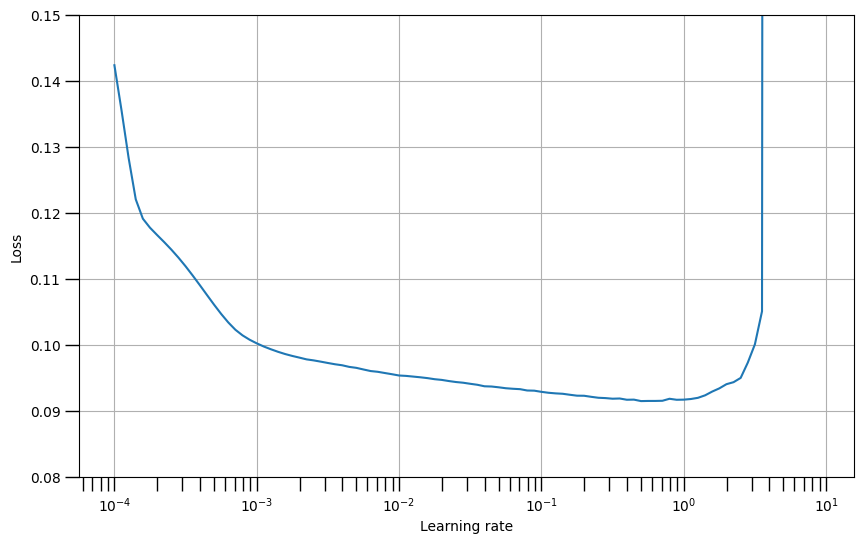

In [37]:
# Define the learning rate array
lrs = 1e-4 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.ylim([0.08, 0.15])

# Model Training

We found that the best learning rate is 10e-3 (or 0.01).
We want the learning rate to decay as the training progresses. This will help us get closer to the minimum of the loss function.


In [38]:
#set the learning rate
initial_learning_rate = 0.01

learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

#set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

In [39]:
#set the callback to stop the training if the validation loss doesn't improve
callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [40]:
#prepare the datasets
train_set = train_dataset.shuffle(BUFFER).batch(BATCH_SIZE).prefetch(1)
val_set = val_dataset.batch(BATCH_SIZE).prefetch(1)

In [42]:
#Reset the states generated by keras
tf.keras.backend.clear_session()

model = create_model(vectorize_layer, normalization_layer)

In [ ]:
#compile and train the model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=500, validation_data = val_set, verbose=2, callbacks=[callback])

In [ ]:
#save the model
!mkdir -p saved_model
model.save('saved_model/my_model')

# Model Evaluation
We plot the the predictions of the model against the actual values.